# Imports

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from google.colab import files
import io

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Makes visualization easier
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

# Problem 1: Titanic

## Code

In [0]:
titanic = sns.load_dataset('titanic')
titanic_clean_age = titanic.dropna(subset=['age']) # remove those rows without an age value

males = titanic_clean_age.loc[titanic_clean_age['sex'] == 'male']     # get only the males
males = males.loc[males['survived'] == 1]                             # filter only the survivors
females = titanic_clean_age.loc[titanic_clean_age['sex'] == 'female'] # get only the females
females = females.loc[females['survived'] == 1]                       # filter only the survivors

### Histogram for Males: age on x-axis and number of survivors on the y-axis

In [0]:
sns.distplot(males['age'], kde=False) # plot the male survivors histogram by age

### Histogram for Females: age on x-axis and number of survivors on the y-axis

In [0]:
sns.distplot(females['age'], kde=False) # plot the female survivors histrogram by age

## Write-Up

Looking at these two distribution plots, we can see that age has a general relationship with survivorship. It is clear that the survivorship data roughly follows a standard distribution, but that is only because the number of samples present in the data also follows a standard distribution for age. What is interesting is the spike in survivorship for children for both genders. This makes sense when contextualized. It is famously known that women and children were given priority on lifeboats, thus increasing the survivorship for those variables. This also explains why women have a higher survivorship in general over the men.

# Problem 2: Auto MPG

## Code

In [0]:
# this code is used to load the data that was downloaded from UCI
from google.colab import files
uploaded = files.upload()

Saving auto-mpg.data to auto-mpg.data


In [0]:
#
# Get The Data, put it into Pandas
#

# This method is used for transforming the data into the appropriate type
def fixNumVals(x):
  if x == '?':
    return np.nan
  else:
    return float(x)

raw = uploaded['auto-mpg.data'].decode('utf-8').split('\n') # raw input
good = [] # will contain the final 2D array

for i in range(len(raw) - 1):
  splitOnTab = raw[i].split('\t')
  splitOnSpace = splitOnTab[0].split(" ")
  
  vehicleName = splitOnTab[1][1:-1] # remove the extra quotes
  splitOnSpace = list(filter(lambda x: x is not '', splitOnSpace)) # remove empty strings
  splitOnSpace = list(map(fixNumVals, splitOnSpace)) # convert strings to floats
  splitOnSpace.append(vehicleName)
  good.append(splitOnSpace)

headers = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]

df = pd.DataFrame.from_records(good, columns = headers)

In [0]:
df.describe()

### Imputation

In [0]:
meanImp = SimpleImputer(missing_values=np.nan, strategy='mean')
medianImp = SimpleImputer(missing_values=np.nan, strategy='median')
modeImp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

hpWithMean = meanImp.fit_transform(df[["horsepower"]]).ravel()
hpWithMedian = medianImp.fit_transform(df[["horsepower"]]).ravel()
hpWithMode = modeImp.fit_transform(df[["horsepower"]]).ravel()

print('Variance of Horsepower with Mean:', np.var(hpWithMean))
print('Variance of Horsepower with Median:', np.var(hpWithMedian))
print('Variance of Horsepower with Mode:', np.var(hpWithMode))

Variance of Horsepower with Mean: 1455.511639831812
Variance of Horsepower with Median: 1457.2982752960781
Variance of Horsepower with Mode: 1486.29231585061


## Write-Up

The imputation with the lowest variance is the one that uses the mean. This is because after the imputation, more samples have a value equal to the mean, which by definition contributes nothing to the variation. Another method for imputation would be to find a relationship among multiple columns and then use regression to find the missing value. However, this method requires more analysis of the existing data.

# Problem 3: Iris

## Code

In [0]:
iris = sns.load_dataset('iris')

features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# .loc parameters: slice of rows to select, slice of features to select
x = iris.loc[:, features].values # separate the features
y = iris.loc[:, ['species']].values # separate the target. This is selecting the 'species' columns with all rows

# calculate variances for each feature before perfoming PCA
irisVars = []
for f in features:
  irisVars.append(iris[[f]].var()[0])
# calculate the total variance
totalVar = sum(irisVars)
# print out the variance ratio for each feature
for f,v in zip(features,irisVars):
  print('Percent of variance from {} ='.format(f), v/totalVar)

x = StandardScaler().fit_transform(x) # standardize the data

pca = PCA() # get a pca object
principalComponents = pca.fit_transform(x) # perform the pca

# Put the new principle components into a pandas dataframe
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', '3', '4'])

print('Variance Ratio after PCA:', pca.explained_variance_ratio_)

Percent of variance from sepal_length = 0.14994532099467353
Percent of variance from sepal_width = 0.04154410732328823
Percent of variance from petal_length = 0.681457931997653
Percent of variance from petal_width = 0.12705263968438513
Variance Ratio after PCA: [0.72962445 0.22850762 0.03668922 0.00517871]


### Visualization for Two Principal Components (not required)

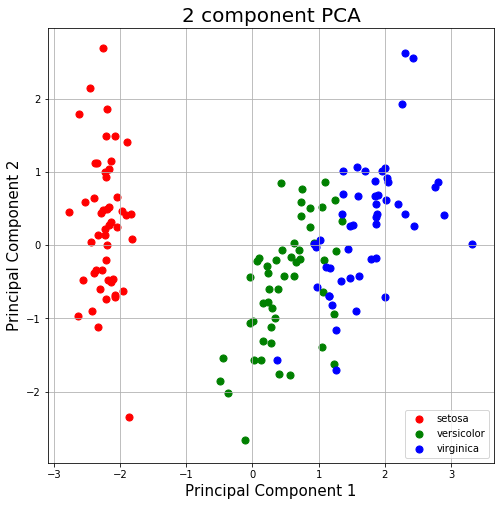

In [0]:
# uncolored, unlabeled visualization code
# plt.scatter(principalDf[['principal component 1']].values, principalDf[['principal component 2']].values)

#
# VISUALIZATION CODE:
# https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#

# this line concatenates the two specified dataframes along the columns because axis = 1
# note that prinicipalDf is the df with the new principal components and 
# iris[['species']] selects the 'species' columns with all rows (exactly like line 7!)
# we do this in order to keep the original datapoints in line with their labels so visualization is easy
finalDf = pd.concat([principalDf, iris[['species']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['setosa', 'versicolor', 'virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['species'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Write-Up

Looking at the percentage of variance explained by the individual features, I notice that one feature in particular, Petal Length, accounts for 68% of the total variance before PCA. This is substantially more than the other features, which fall in at 15%, 13%, and 4%. Similarly, when I look at the percentage of variance explained by each of the principal components after PCA, I notice that one accounts for most of the variance at 73%. This is by design of PCA. For other data sets, there may not be one single feature that accounts for more variance than any others, but PCA will ensure that the First Principal Component captures a substantial amount of variance.

# Problem 4: Iris Continued

## Visualization Code

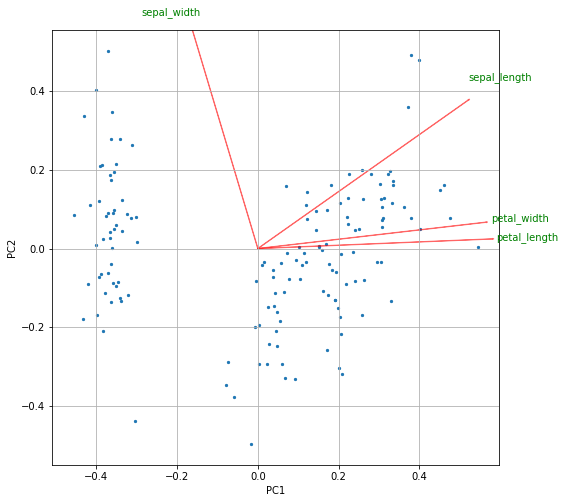

In [0]:
# https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
def myplot(score,coeff,labels=None):
  xs = score[:,0]
  ys = score[:,1]
  n = coeff.shape[0]
  scalex = 1.0/(xs.max() - xs.min())
  scaley = 1.0/(ys.max() - ys.min())
  plt.scatter(xs * scalex,ys * scaley,s=5)
  for i in range(n):
    plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
    if labels is None:
      plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
    else:
      # this hack makes the sepal_width label look better
      if labels[i] == 'sepal_width':
        plt.text(coeff[i,0]*0.8, coeff[i,1]*0.65, labels[i], color = 'g', ha = 'center', va = 'center')
      else:
        plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
  plt.xlabel("PC{}".format(1))
  plt.ylabel("PC{}".format(2))
  plt.grid()


myplot(principalComponents[:,0:2],np.transpose(pca.components_[0:2, :]),list(features))
plt.show()

## Correlation Code

In [0]:
# features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

# Concatenate the original features with the first principle component
pc1_sepal_length = pd.concat([principalDf.loc[:, ['principal component 1']], iris[[features[0]]]], axis = 1)
pc1_sepal_width = pd.concat([principalDf.loc[:, ['principal component 1']], iris[[features[1]]]], axis = 1)
pc1_petal_length = pd.concat([principalDf.loc[:, ['principal component 1']], iris[[features[2]]]], axis = 1)
pc1_petal_width = pd.concat([principalDf.loc[:, ['principal component 1']], iris[[features[3]]]], axis = 1)

print('Sepal Length and PC1 Correlation:', pc1_sepal_length.corr().iloc[0,1])
print('Sepal Width and PC1 Correlation:', pc1_sepal_width.corr().iloc[0,1])
print('Petal Length and PC1 Correlation:', pc1_petal_length.corr().iloc[0,1])
print('Petal Width and PC1 Correlation:', pc1_petal_width.corr().iloc[0,1])

Sepal Length and PC1 Correlation: 0.8901687648612948
Sepal Width and PC1 Correlation: -0.4601427064479082
Petal Length and PC1 Correlation: 0.9915551834193609
Petal Width and PC1 Correlation: 0.9649789606692489


## Write-Up

After looking at the biplot above, and knowing that the First Principal Component is on the x-axis, it is clear that Petal Length and Petal Width have the closest relationships to the First Principal Component. This is because the angle between these features and the First Principal Component is the closest to zero, therefore maximizing the cosine of that angle, which is generally used to show correlation between two vectors. After calculating the actual correlation coefficients between each feature and the First Principal Component, we can see that the results are in agreement. Petal Length and Petal Width have by far the highest correlation with the First Principal Component, while Sepal Width is negative, which agrees with the cosine of its angle, because the angle between the Sepal Width and the First Principal Component is greater than 90 degrees.

# Problem 5: Iris Continued

## Code

In [0]:
#
# TOTAL VARIANCE IN THE ORIGINAL IRIS DATASET
#

totalVarOriginal = 0
for f in features:
  v = iris[[f]].var()[0]
  print('Variance for {} before PCA:'.format(f), v)
  totalVarOriginal += v

print('Total Original Variance:', totalVarOriginal)

Variance for sepal_length before PCA: 0.6856935123042505
Variance for sepal_width before PCA: 0.1899794183445188
Variance for petal_length before PCA: 3.1162778523489942
Variance for petal_width before PCA: 0.5810062639821029
Total Original Variance: 4.572957046979867


In [0]:
#
# PERFORM PCA AGAIN, THIS TIME WITH ALL FEATURES TO GET ALL EIGENVECTORS
#

# .loc parameters: slice of rows to select, slice of features to select
x = iris.loc[:, features[:4]].values # separate the features
y = iris.loc[:, ['species']].values # separate the target. This is selecting the 'species' columns with all rows

x = StandardScaler().fit_transform(x) # standardize the data

pca4 = PCA(n_components=4) # get a pca object
newComps = pca4.fit_transform(x) # perform the pca

# this a dataframe identical to iris, but without the target feature
xDF = pd.DataFrame(data = x, columns = features[:4])
# this is a dataframe with all four eigenvectors
newCompsDF = pd.DataFrame(data = newComps, columns = ['pc'+str(k) for k in range(1,5)])

#
# PERCENTAGE OF VARIANCE EXPLAINED WITH N COMPONENTS
#
sum = 0
n = 2
# sum the first n variance ratios
for i in pca4.explained_variance_ratio_[:n]:
  sum += i
print('Percentage Variance Explained with {} components:'.format(n), sum)

#
# TOTAL VARARIANCE CAPTURED IN THE FOUR EIGENVECTORS
#
totalVarPCA = 0
for f in newCompsDF.columns:
  v = newCompsDF[[f]].var()[0]
  print('Variance for {} after PCA:'.format(f), v)
  totalVarPCA += v

print('Total PCA Variance:', totalVarPCA)

Percentage Variance Explained with 2 components: 0.9581320720000164
Variance for pc1 after PCA: 2.938085050199998
Variance for pc2 after PCA: 0.9201649041624874
Variance for pc3 after PCA: 0.14774182104494782
Variance for pc4 after PCA: 0.020853862176462276
Total PCA Variance: 4.026845637583896


## Write-Up

I notice that the variance for the Petal Length feature is by far the highest, and  the variance for the First Principal Component is also by far the highest. I know that this makes sense after looking at the correlations in the previous problem, because Petal Length and the First Principal Component are by far have the highest correlation. If we wanted to capture at least 95% of the variance, we would only need two principal components, as described above in the code that sums the explained variance ratios. This happens to be exactly the number of dimensions to which we are reducing the dataset because the PCA finds and uses the eigenvalues accordingly so that the maximum variance is captured in the fewest eigenvectors. 